In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
import matplotlib.animation as animation
from IPython.display import display, Markdown, clear_output, HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time as tm

In [34]:
# Parameters
g = 9.81  # Gravity (m/s^2)
L1 = 8814e3  # Distance Tokyo to LA (m)
L2 = 4688e3  # Distance Tokyo to New Guinea (m)
Nx = 256  # Number of grid points in x
Ny = 256  # Number of grid points in y
dx = L1 / (Nx - 1)  # Grid spacing in x
dy = L2 / (Ny - 1)  # Grid spacing in y
x = np.linspace(0, L1, Nx)
y = np.linspace(0, L2, Ny)
X, Y = np.meshgrid(x, y)
dt = 10  # Time step (s) - adjust for stability
hours = 3.5  # Simulation time (hours)
t_end = 3600 * hours  # Simulation time
time = np.arange(0, t_end, dt)
Nt = len(time)

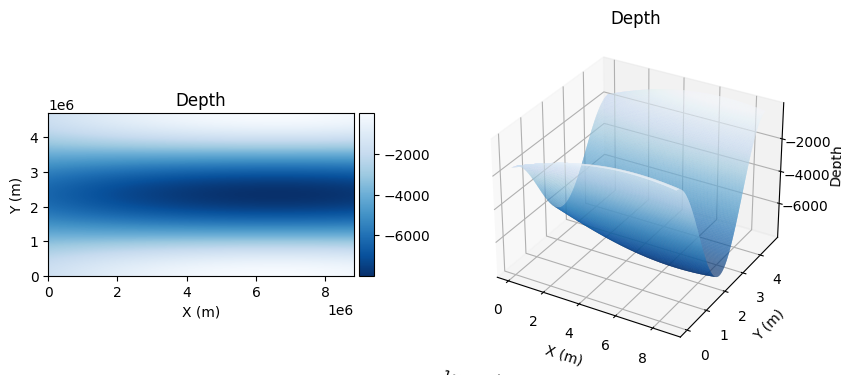

In [35]:
# Depth function (average 4km, sinusoidal variation)
def depth(x, y):
    return 4000 * (1+np.sin(2 * np.pi * (x-2*L1) / (5*L1)) * np.cos(2 * np.pi * y / L2))

D = depth(X, Y)

# Set up the figure and axes
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

# Plot the depth as imshow
im = ax1.imshow(-D, extent=[0, L1, 0, L2], origin='lower', cmap='Blues_r')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(im, cax=cax)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_title('Depth')
ax1.margins(0, 0)

# Plot the depth as surface
ax2.plot_trisurf(X.flatten(), Y.flatten(), -D.flatten(), cmap='Blues_r')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_zlabel('Depth')
ax2.set_title('Depth')

fig.subplots_adjust(top=1.0,bottom=0.06,left=0.049,right=0.987,hspace=0.205,wspace=0.303)
plt.show()

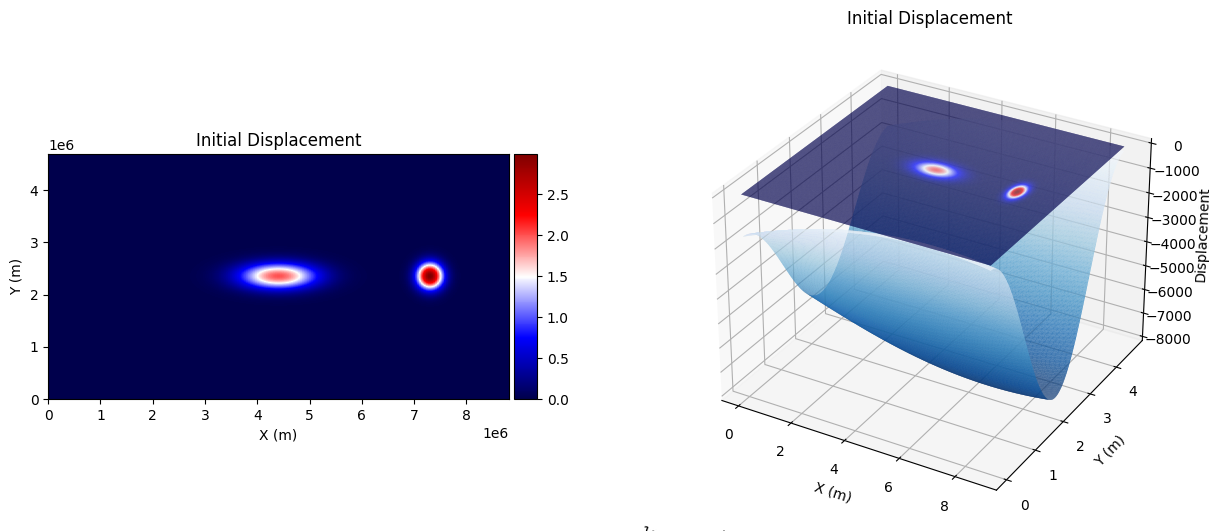

In [36]:
# Initial conditions
x0 = L1 / 2
y0 = L2 / 2
sigma = L1 / 50

# Initial displacement (Gaussian pulse)
def initial_displacement(x, y, x0, y0, sigma):
    return (2*np.exp(-(((x - x0)/3)**2 / (2 * sigma**2) + ((y - y0))**2 / (2 * sigma**2))) + 3*np.exp(-((x - L1+1.5e6)**2 / (2 * sigma**2) + ((y -y0))**2 / (2 * sigma**2))))

eta = initial_displacement(X, Y, x0, y0, sigma)
eta_t = np.zeros(eta.shape)  # Initial velocity

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

# Plot the initial displacement as imshow
im = ax1.imshow(eta, extent=[0, L1, 0, L2], origin='lower', cmap='seismic')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(im, cax=cax)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_title('Initial Displacement')
ax1.margins(0, 0)

# Plot the initial displacement as surface
ax2.plot_trisurf(X.flatten(), Y.flatten(), eta.flatten(), cmap='seismic')
ax2.plot_trisurf(X.flatten(), Y.flatten(), -D.flatten(), cmap='Blues_r')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_zlabel('Displacement')
ax2.set_title('Initial Displacement')
ax2.set_zlim(np.min(-D)-10, 10)

fig.subplots_adjust(top=1.0,bottom=0.06,left=0.049,right=0.987,hspace=0.205,wspace=0.303)
plt.show()

In [37]:
# Wavenumbers
kx = 2 * np.pi * np.fft.fftfreq(Nx, d=dx)
ky = 2 * np.pi * np.fft.fftfreq(Ny, d=dy)
KX, KY = np.meshgrid(kx, ky)

# Function to update the plot
def update_plot(frame):
    global eta, eta_t, im, ax2
    display(Markdown(f'Frame {frame + 1} out of {Nt}'))
    # Spatial derivatives in Fourier space
    eta_hat = fft2(eta)
    eta_xx_hat = -(KX**2) * eta_hat  # Second derivative in x
    eta_yy_hat = -(KY**2) * eta_hat  # Second derivative in y

    # Inverse FFT to get derivatives in spatial domain
    eta_x_x = np.real(ifft2(eta_xx_hat))
    eta_y_y = np.real(ifft2(eta_yy_hat))

    # RK4 stages
    k1_eta = eta_t
    k1_eta_t = g * D * (eta_x_x + eta_y_y)

    eta_temp = eta + 0.5 * dt * k1_eta

    eta_temp_hat = fft2(eta_temp)

    eta_x_x_temp_hat = -(KX**2) * eta_temp_hat
    eta_y_y_temp_hat = -(KY**2) * eta_temp_hat

    eta_x_x_temp = np.real(ifft2(eta_x_x_temp_hat))
    eta_y_y_temp = np.real(ifft2(eta_y_y_temp_hat))

    k2_eta = eta_t + 0.5 * dt * k1_eta_t
    k2_eta_t = g * D * (eta_x_x_temp + eta_y_y_temp)

    eta_temp = eta + 0.5 * dt * k2_eta

    eta_temp_hat = fft2(eta_temp)

    eta_x_x_temp_hat = -(KX**2) * eta_temp_hat
    eta_y_y_temp_hat = -(KY**2) * eta_temp_hat

    eta_x_x_temp = np.real(ifft2(eta_x_x_temp_hat))
    eta_y_y_temp = np.real(ifft2(eta_y_y_temp_hat))

    k3_eta = eta_t + 0.5 * dt * k2_eta_t
    k3_eta_t = g * D * (eta_x_x_temp + eta_y_y_temp)

    eta_temp = eta + dt * k3_eta

    eta_temp_hat = fft2(eta_temp)

    eta_x_x_temp_hat = -(KX**2) * eta_temp_hat
    eta_y_y_temp_hat = -(KY**2) * eta_temp_hat

    eta_x_x_temp = np.real(ifft2(eta_x_x_temp_hat))
    eta_y_y_temp = np.real(ifft2(eta_y_y_temp_hat))

    k4_eta = eta_t + dt * k3_eta_t
    k4_eta_t = g * D * (eta_x_x_temp + eta_y_y_temp)

    # Update eta and eta_t
    eta = eta + (dt / 6) * (k1_eta + 2 * k2_eta + 2 * k3_eta + k4_eta)
    eta_t = eta_t + (dt / 6) * (k1_eta_t + 2 * k2_eta_t + 2 * k3_eta_t + k4_eta_t)

    # Update the plot
    im.set_data(eta)
    ax1.set_title(f'Displaiment at t = {(frame * dt/3600):.2f} h')

    # Update the data for the 3D plot
    ax2.clear()
    ax2.plot_surface(X, Y, eta, cmap='seismic')
    ax2.plot_surface(X, Y, -D, cmap='Blues_r')
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.set_zlabel('Displacement')
    ax2.set_title('Initial Displacement')
    ax2.set_title(f'Displaiment at t = {(frame * dt/3600):.2f} h')
    ax2.set_zlim(np.min(-D)-10, 10)
    clear_output(wait=True)

    return im,

# Create the animation
ani = animation.FuncAnimation(fig, update_plot, frames=Nt, blit=True, repeat=False)

# Save the animation as an MP4 file
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Juan David Martinez XD'), bitrate=1800)
ani.save(f'tsunami_simulation_{int(tm.time())}.mp4', writer=writer)

plt.show()
display(HTML('<h1>Simulation complete!</h1>'))